In [7]:
#import libraries and set the vectorBT portfolio settings
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
from numba import njit

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [8]:
import yfinance as yf

# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

In [9]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores = indicadores.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores.index))  # Deve retornar True se estiverem alinhados

True


In [10]:
# TODO: Tomar cuidado com rebalancear em dias seguidos
# Se passou, não rebalancear enquanto não voltar ao limite

upper_threshold = 75
lower_threshold = 25

entries = indicadores < lower_threshold
exits = indicadores > upper_threshold

In [11]:
import riskfolio as rp
import pandas as pd

# TODO: Verificar quantidade de tempo para rebalanceamento
# TODO: Constraints da otimização
def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # Usando Ledoit-Wolf shrinkage para tornar a matriz de cov positiva definida

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores[entries | exits]
indicadores_limite.sort_index(inplace=True)

pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-08-07,9.402251e-03,5.369620e-03,9.543454e-10,9.318886e-10,1.044926e-09,6.436507e-09,3.958341e-09,1.041723e-02,1.083302e-03,1.516685e-09,...,0.018254,1.031611e-08,3.568228e-03,0.004270,5.138091e-09,2.758947e-09,7.961301e-09,1.013961e-02,3.545822e-02,3.923637e-09
2015-08-24,1.023942e-02,5.796098e-03,5.097097e-09,5.558426e-09,6.052018e-09,5.291666e-08,1.405686e-08,1.166633e-02,1.604743e-03,9.520285e-09,...,0.017568,5.199495e-08,2.271003e-03,0.004872,3.445506e-08,8.111614e-09,2.209649e-08,7.893029e-03,3.303802e-02,7.921423e-08
2015-09-02,1.031329e-02,4.704729e-03,5.016309e-10,5.457376e-10,5.824766e-10,4.040968e-09,1.138012e-09,1.215629e-02,2.647480e-03,9.296376e-10,...,0.016827,3.170809e-09,1.657398e-03,0.004166,2.757586e-09,8.171634e-10,1.386738e-09,7.082940e-03,3.223866e-02,1.897931e-08
2015-09-22,1.093866e-02,6.313835e-03,3.212266e-09,3.698040e-09,3.752490e-09,4.393922e-08,1.015886e-08,1.410225e-02,3.327835e-03,5.831330e-09,...,0.016068,2.659448e-08,1.651361e-03,0.004018,2.247343e-08,8.113070e-09,1.110388e-08,7.830996e-03,3.143604e-02,2.924280e-07
2015-09-25,1.108461e-02,5.586405e-03,1.271651e-09,1.478460e-09,1.504096e-09,1.556677e-08,3.708708e-09,1.493545e-02,3.755507e-03,2.307047e-09,...,0.016511,1.245910e-08,1.668632e-03,0.003553,8.639054e-09,2.672498e-09,4.048434e-09,7.126850e-03,3.062118e-02,3.998901e-05
2015-09-28,1.117308e-02,5.515225e-03,1.387705e-09,1.620538e-09,1.653001e-09,1.619186e-08,3.912525e-09,1.493014e-02,3.686140e-03,2.533342e-09,...,0.016863,1.244847e-08,1.596533e-03,0.003362,9.272544e-09,2.932584e-09,4.179808e-09,7.141262e-03,3.028556e-02,3.654335e-05
2015-09-29,1.123348e-02,5.206387e-03,1.689319e-09,1.970082e-09,2.017193e-09,2.060474e-08,4.704833e-09,1.491885e-02,3.734167e-03,3.049272e-09,...,0.016738,1.603480e-08,1.552322e-03,0.003434,1.156187e-08,3.505664e-09,5.019663e-09,7.185934e-03,3.050782e-02,2.572042e-05
2015-12-14,4.815970e-03,1.046289e-07,1.900317e-09,3.355935e-09,3.023296e-09,1.076345e-08,5.003762e-09,1.994666e-02,4.016431e-03,6.462993e-09,...,0.027932,7.735320e-04,5.328073e-08,0.005972,1.300631e-08,1.080406e-03,6.690353e-09,1.538603e-02,2.433127e-02,2.563144e-08
2015-12-16,4.221848e-03,7.034549e-05,5.022362e-10,8.818291e-10,7.970699e-10,2.734069e-09,1.366980e-09,1.984533e-02,3.914721e-03,1.638920e-09,...,0.027800,6.077280e-04,1.889328e-08,0.006254,3.543124e-09,1.239476e-03,1.749390e-09,1.541724e-02,2.397741e-02,7.767190e-09
2016-01-18,2.040368e-03,1.058087e-03,3.267909e-10,5.690319e-10,5.265082e-10,1.344991e-09,7.181817e-10,1.860607e-02,5.210743e-03,8.978322e-10,...,0.028279,1.714277e-03,7.107469e-09,0.005306,1.849034e-09,2.564695e-04,1.038509e-09,1.160432e-02,2.181010e-02,1.320443e-08


c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


<Axes: title={'center': 'Equity Progression'}>

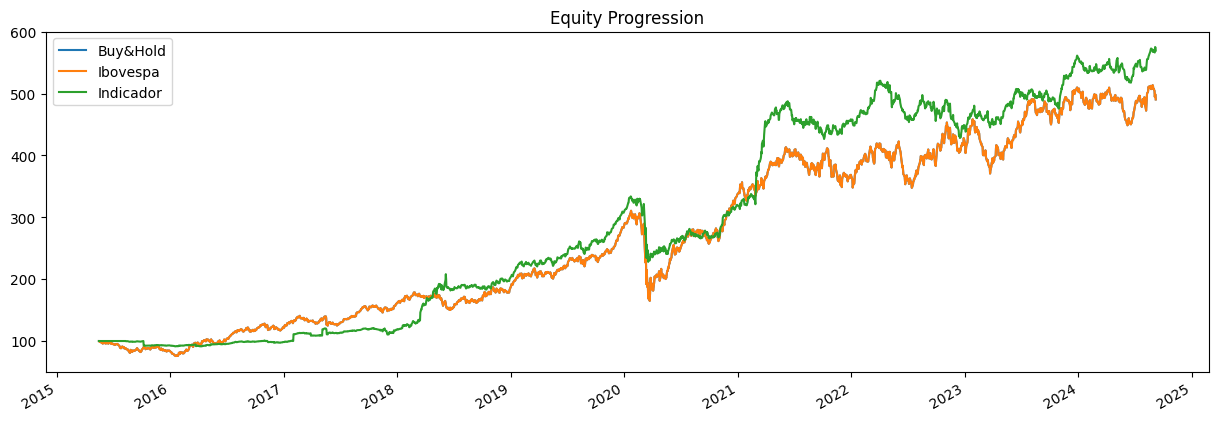

In [12]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Assumindo que você já tem um DataFrame 'prices' com os dados de preços de ações
# Exemplo:
# prices = yf.download(['AAPL', 'MSFT', 'GOOG'], start='2020-01-01', end='2024-01-01')['Adj Close']

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia diária
strat_daily = bt.Strategy('Diário', [
    bt.algos.RunDaily(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia mensal
strat_monthly = bt.Strategy('Mensal', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia anual
strat_annual = bt.Strategy('Anual', [
    bt.algos.RunYearly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))['Adj Close']

# Normalizando o índice Ibovespa para combinar com o DataFrame de preços
ibov = ibov.pct_change().dropna()

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])

# Criando o backtest
backtests = [
    bt.Backtest(strat_buy_hold, prices, initial_capital=10000),
    # bt.Backtest(strat_daily, prices, initial_capital=10000),
    # bt.Backtest(strat_monthly, prices, initial_capital=10000),
    # bt.Backtest(strat_annual, prices, initial_capital=10000),
    bt.Backtest(strat_ibov, prices, initial_capital=10000),
    bt.Backtest(strat_indicador, prices, initial_capital=10000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [13]:
# Resultados
results.display()

Stat                 Buy&Hold    Ibovespa    Indicador
-------------------  ----------  ----------  -----------
Start                2015-05-17  2015-05-17  2015-05-17
End                  2024-09-06  2024-09-06  2024-09-06
Risk-free rate       0.00%       0.00%       0.00%

Total Return         390.49%     390.49%     469.39%
Daily Sharpe         0.86        0.86        1.15
Daily Sortino        1.32        1.32        1.91
CAGR                 18.63%      18.63%      20.55%
Max Drawdown         -46.90%     -46.90%     -31.70%
Calmar Ratio         0.40        0.40        0.65

MTD                  -3.42%      -3.42%      -0.13%
3m                   7.92%       7.92%       8.14%
6m                   1.38%       1.38%       6.81%
YTD                  -3.79%      -3.79%      1.44%
1Y                   4.24%       4.24%       15.93%
3Y (ann.)            8.93%       8.93%       7.81%
5Y (ann.)            16.01%      16.01%      17.97%
10Y (ann.)           18.63%      18.63%      20.55%
Sin

In [17]:
trans = results.get_transactions('Indicador')

In [19]:
trans

price  quantity
Date       Security                     
2015-08-07 ABEV3.SA  14.226474       6.0
           ALPA4.SA   5.404266       9.0
           BRFS3.SA  65.516464       1.0
           BRKM5.SA   8.704030       1.0
           EMBR3.SA  23.710979       8.0
...                        ...       ...
2024-08-05 TIMS3.SA  17.036510      -4.0
           TRPL4.SA  24.389999    -158.0
           VALE3.SA  57.020000      19.0
           VIVT3.SA  48.672100     -59.0
           WEGE3.SA  48.798908      38.0

[569 rows x 2 columns]